In [1]:
# import necessary packages 
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

### Create the customized DataSet

In [2]:
# sort and get the list of images and annotations 
root = './'
imgs = list(sorted(os.listdir(os.path.join(root,'images'))))
annot = list(sorted(os.listdir(os.path.join(root,'annotations'))))

The annotation files are in the xml format so we can use the BeautifulSoup package to extract the informaion of the labels and bounding boxes. Let's create some helper function for this tasks

In [3]:
def get_target(idx):
    with open(os.path.join(root,'annotations',annot[idx])) as f:
        data = f.read()
        soup = BeautifulSoup(data,'xml')
        objects = soup.find_all('object')
        num_obj = len(objects)
        
        # initialize the bboxes and labels
        bboxes = []
        labels = []
        
        for obj in objects:
            # find the bounding boxes
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            xmax = int(obj.find('xmax').text)
            ymax = int(obj.find('ymax').text)
            bboxes.append([xmin, ymin, xmax, ymax])
            
            # define the lables
            if obj.find('name').text == 'with_mask':
                labels.append(1)
            elif obj.find('name').text == 'mask_weared_incorrect':
                labels.append(2)
            else:
                labels.append(3)
        
        # convert the bboxes and labels into tensor format
        bboxes = torch.tensor(bboxes,dtype=torch.float32)
        labels = torch.tensor(labels,dtype=torch.int64)
        
        # create the target dictionary for __getitem__ method later in the dataset class
        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx,dtype=torch.int64)
        
        return target

Let's plot one sample to see how the helper function works 

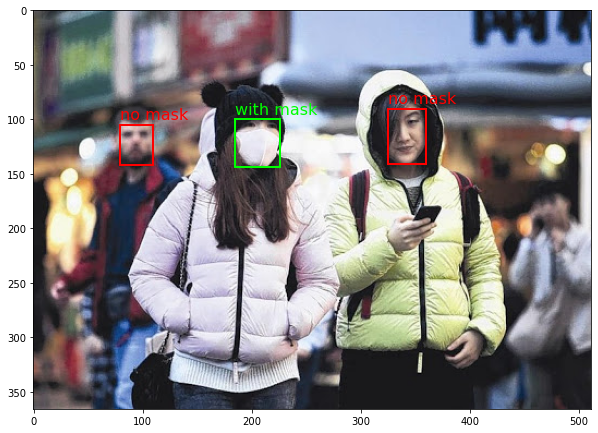

In [4]:
# extract the information from the 1st picture
target = get_target(0)
img = Image.open(os.path.join(root,'images',imgs[0])).convert('RGB')


# deinfe the plot result function to plot both the original image and the bounding boxes.
def PlotResult(img, boxes, labels):
    fig, ax = plt.subplots()
    ax.imshow(img)
    for i, j in zip(boxes, labels):
    
        # get the coordincate of the bounding box and the label
        xmin = i.numpy()[0]
        ymin = i.numpy()[1]
        xmax = i.numpy()[2]
        ymax = i.numpy()[3]
        w = xmax - xmin
        h = ymax - ymin
        label = j.numpy()
    
        # plot the bounding box and add annotation
        if label==1:
            rect = Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            plt.annotate('with mask',(xmin,ymin-5), color = 'lime',size=16)
        elif label == 2:
            rect = Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor='orange', facecolor='none')
            plt.annotate('weared incorrectly',(xmin,ymin-5), color = 'orange', size = 16)
        else:
            rect = Rectangle((xmin, ymin), w, h, linewidth=2, edgecolor='red', facecolor='none')
            plt.annotate('no mask',(xmin,ymin-5), color = 'red',size=16)
        ax.add_patch(rect)
    fig.set_size_inches(10,8)
    
PlotResult(img, target['boxes'], target['labels'])

Looks like the function works as we expected. Now we can create our customized dataset so that we can use it in the DataLoader

In [5]:
class MaskDataSet(Dataset):
    "Face mask dataset"
    def __init__(self, transforms=None):
        # list of the images
        self.imgs = imgs
        
        # transform function to be defined later
        self.transforms = transforms
    
    def __getitem__(self, idx):
        
        target = get_target(idx)
        img = Image.open(os.path.join(root,'images',imgs[idx])).convert('RGB')
        
        # normalize the image and convert it to tensor format
        if self.transforms is not None:
            img = self.transforms(img)
        
        return img, target
        
    def __len__(self): # this is the necessary method for DataLoader to get the number of samples
        return len(self.imgs)

Create the transform function for the image, here we will only use ToTensor method to normalize the image and convert the image to tensor format

In [6]:
image_transform = transforms.Compose([transforms.ToTensor()])

Since each image has different dimenstions in our dataset and each image may have different numbers of objects, we need to use the collate function to organize the batch so that it can be read from DataLoader

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

Now we can create the dataset and load it using DataLoader

In [8]:
mydata = MaskDataSet(transforms = image_transform)

# create train dataset and test dataset
indices = list(range(len(mydata)))
mydata_train = Subset(mydata, indices[:-50])
mydata_test = Subset(mydata, indices[-50:])

# create datdaloader for dataset and test dataset
mydata_loader = DataLoader(mydata_train, batch_size = 4, collate_fn = collate_fn, shuffle = True)
mydata_loader_test = DataLoader(mydata_test, batch_size = 1, collate_fn = collate_fn, shuffle = False)

### Create the FasterRCNN model

We use ResNet50 as the backbone of the FasterRCNN

In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [10]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [11]:
model = get_model_instance_segmentation(4)

### Model training

In [12]:
# check if GPU is available or not
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [13]:
# define the number of epoch
num_epoch = 30

# move model to GPU
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

In [15]:
loss_per_epoch = []
for epoch in range(num_epoch):
    model.train()
    epoch_loss = 0
    for images, targets in mydata_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses
    loss_per_epoch.append(epoch_loss)
    print('epoch:{}, loss:{}'.format((epoch+1),epoch_loss))

epoch:1, loss:87.27669525146484
epoch:2, loss:56.875057220458984
epoch:3, loss:46.94748306274414
epoch:4, loss:41.603336334228516
epoch:5, loss:36.6197395324707
epoch:6, loss:33.054874420166016
epoch:7, loss:29.91877555847168
epoch:8, loss:27.426971435546875
epoch:9, loss:25.657732009887695
epoch:10, loss:23.405933380126953
epoch:11, loss:21.544269561767578
epoch:12, loss:20.57811737060547
epoch:13, loss:19.911701202392578
epoch:14, loss:18.458703994750977
epoch:15, loss:18.560903549194336
epoch:16, loss:17.37959861755371
epoch:17, loss:17.16809844970703
epoch:18, loss:14.96916389465332
epoch:19, loss:14.408782005310059
epoch:20, loss:14.156353950500488
epoch:21, loss:13.517179489135742
epoch:22, loss:13.061210632324219
epoch:23, loss:12.901312828063965
epoch:24, loss:13.068231582641602
epoch:25, loss:13.173420906066895
epoch:26, loss:12.641608238220215
epoch:27, loss:12.321162223815918
epoch:28, loss:11.613054275512695
epoch:29, loss:11.58181381225586
epoch:30, loss:10.765861511230469

### Model evaludation

We will use the mean average precision (mAP) as the performance metrics for our model. As the start, we first create two separate files to represent the ground truths and the detection

In [26]:
# create the ground truths and detections files for later mAP calculation
for image, target in mydata_loader_test:
    model.eval()
    with torch.no_grad():
        img = image[0].to(device)
        pred = model([img])
        
        idx = target[0]['image_id']
        idx = idx.numpy()
        filename_gt = imgs[idx][:-4] + '.xml'
        filename = imgs[idx][:-4] + '.txt'
        
        # get the ground truth files
        with open(os.path.join(root,'annotations',filename_gt)) as f:
            data = f.read()
            soup = BeautifulSoup(data,'xml')
            objects = soup.find_all('object')
            num_obj = len(objects)       
        
            for obj in objects:
                # find the bounding boxes
                xmin = int(obj.find('xmin').text)
                ymin = int(obj.find('ymin').text)
                xmax = int(obj.find('xmax').text)
                ymax = int(obj.find('ymax').text)
                w = xmax - xmin
                h = ymax - ymin
        
                # write to text file
                gt = open(os.path.join('./groundtruths',filename),'a')
                gt.write(obj.find('name').text + ' ' + str(xmin) + ' ' + str(ymax) + ' ' + str(w) + ' ' + str(h) + '\n')
                gt.close()
        
        # get the detection files
        for i in range(len(pred[0]['boxes'])):
            label = ''
            xmin = pred[0]['boxes'].cpu().numpy()[i][0]
            ymin = pred[0]['boxes'].cpu().numpy()[i][1]
            xmax = pred[0]['boxes'].cpu().numpy()[i][2]
            ymax = pred[0]['boxes'].cpu().numpy()[i][3]
            w = xmax - xmin
            h = ymax - ymin
            score = pred[0]['scores'].cpu().numpy()[i]
            if pred[0]['labels'][i] == 1:
                label = 'with_mask'
            elif pred[0]['labels'][i] == 2:
                label = 'mask_weared_incorrect'
            else:
                label = 'without_mask'
            
            f = open(os.path.join('./detections',filename),'a')
            f.write(label + ' ' + str(score) + ' ' +str(xmin) + ' ' + str(ymax) + ' ' + str(w) + ' ' + str(h) + '\n')
            f.close()

For calculating the mAP, we use the package written by (https://github.com/rafaelpadilla/Object-Detection-Metrics). The following function helps to get the boundingboxes with corresponding classesf for mAP calculation

In [17]:
import _init_paths
from utils2 import *
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import *

In [27]:
def getBoundingBoxes():
    """Read txt files containing bounding boxes (ground truth and detections)."""
    allBoundingBoxes = BoundingBoxes()
    import glob
    # Read ground truths
    currentPath = os.getcwd()
    folderGT = os.path.join(currentPath,'groundtruths')
    os.chdir(folderGT)
    files = glob.glob("*.txt")
    files.sort()
    # Class representing bounding boxes (ground truths and detections)
    allBoundingBoxes = BoundingBoxes()
    # Read GT detections from txt file
    # Each line of the files in the groundtruths folder represents a ground truth bounding box (bounding boxes that a detector should detect)
    # Each value of each line is  "class_id, x, y, width, height" respectively
    # Class_id represents the class of the bounding box
    # x, y represents the most top-left coordinates of the bounding box
    # x2, y2 represents the most bottom-right coordinates of the bounding box
    for f in files:
        nameOfImage = f.replace(".txt","")
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n","")
            if line.replace(' ','') == '':
                continue
            splitLine = line.split(" ")
            idClass = splitLine[0] #class
            x = float(splitLine[1]) #confidence
            y = float(splitLine[2])
            w = float(splitLine[3])
            h = float(splitLine[4])
            bb = BoundingBox(nameOfImage,idClass,x,y,w,h,CoordinatesType.Absolute, (200,200), BBType.GroundTruth, format=BBFormat.XYWH)
            allBoundingBoxes.addBoundingBox(bb)
        fh1.close()
    # Read detections
    folderDet = os.path.join(currentPath,'detections')
    os.chdir(folderDet)
    files = glob.glob("*.txt")
    files.sort()
    # Read detections from txt file
    # Each line of the files in the detections folder represents a detected bounding box.
    # Each value of each line is  "class_id, confidence, x, y, width, height" respectively
    # Class_id represents the class of the detected bounding box
    # Confidence represents the confidence (from 0 to 1) that this detection belongs to the class_id.
    # x, y represents the most top-left coordinates of the bounding box
    # x2, y2 represents the most bottom-right coordinates of the bounding box
    for f in files:
        # nameOfImage = f.replace("_det.txt","")
        nameOfImage = f.replace(".txt","")
        # Read detections from txt file
        fh1 = open(f, "r")
        for line in fh1:
            line = line.replace("\n","")
            if line.replace(' ','') == '':
                continue            
            splitLine = line.split(" ")
            idClass = splitLine[0] #class
            confidence = float(splitLine[1]) #confidence
            x = float(splitLine[2])
            y = float(splitLine[3])
            w = float(splitLine[4])
            h = float(splitLine[5])
            bb = BoundingBox(nameOfImage, idClass,x,y,w,h,CoordinatesType.Absolute, (200,200), BBType.Detected, confidence, format=BBFormat.XYWH)
            allBoundingBoxes.addBoundingBox(bb)
        fh1.close()
    return allBoundingBoxes
    
# Read txt files containing bounding boxes (ground truth and detections)
boundingboxes = getBoundingBoxes()

In [28]:
evaluator = Evaluator()

Create the mAP dataframe to store the mAP result from threhold 0.5 to threshold 0.95

In [29]:
mAP = pd.DataFrame({'class':['mask weared incorrect','with mask','without mask']})

for thres in np.arange(0.5, 1, 0.05):
    result = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=thres)
    AvgPrecision = []
    for i in result:
        AvgPrecision.append(round(i['AP'],3))
    mAP['mAP({})'.format(round(thres,2))] = AvgPrecision
mAP['mAP(0.50:0.95)'] = round(mAP.mean(axis=1),3)
mAP.set_index('class')  

,mAP(0.5),mAP(0.55),mAP(0.6),mAP(0.65),mAP(0.7),mAP(0.75),mAP(0.8),mAP(0.85),mAP(0.9),mAP(0.95),mAP(0.50:0.95)
class,,,,,,,,,,,
mask weared incorrect,0.600,0.600,0.600,0.600,0.600,0.600,0.514,0.375,0.042,0.000,0.453
with mask,0.864,0.837,0.815,0.765,0.647,0.524,0.267,0.133,0.049,0.001,0.490
without mask,0.765,0.765,0.671,0.565,0.538,0.415,0.260,0.091,0.011,0.000,0.408


So after training, we obtain a mAP of 45.3 for the mask weared incorrect class, 49.0 for with mask class and 40.8 for without mask class. In the figure below we plot the precision vs recall curve for all 3 different classes with threshold = 0.75

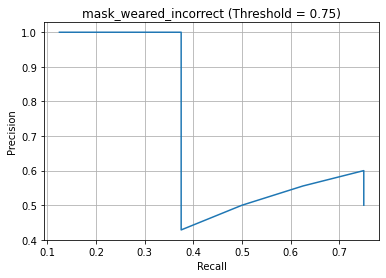

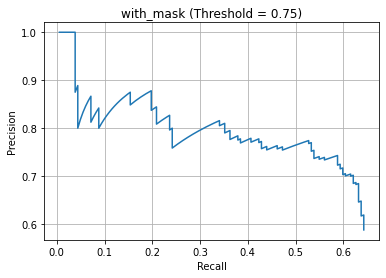

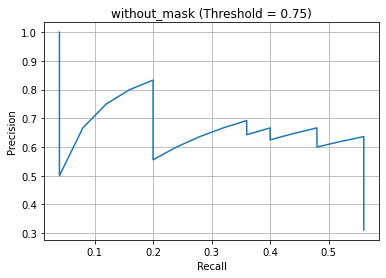

In [30]:
result = evaluator.GetPascalVOCMetrics(boundingboxes, IOUThreshold=0.75)
for i in result:
    plt.figure()
    _=plt.plot(i['recall'], i['precision'])
    _=plt.ylabel('Precision')
    _=plt.xlabel('Recall')
    _=plt.title('{} (Threshold = {})'.format(i['class'],0.75))
    _=plt.grid()

Let's pick some test samples and check the prediction results

In [31]:
os.chdir("\\Springboard\\Springboard\\FaceMaskDetection")

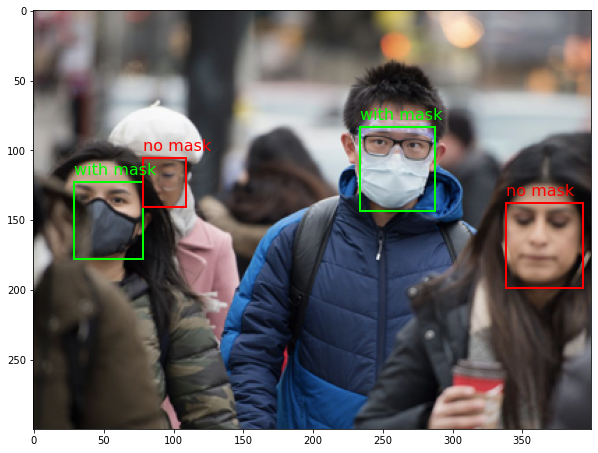

In [32]:
TestImage = Image.open('./images/maksssksksss86.png').convert('RGB')
TestImageV2 = image_transform(TestImage)
TestImageV2 = TestImageV2.to(device)
with torch.no_grad():
    pred = model([TestImageV2])

boxes = pred[0]['boxes'].cpu()
labels = pred[0]['labels'].cpu()
scores = pred[0]['scores'].cpu()   

PlotResult(TestImage, boxes, labels)

The result looks pretty good for no mask and with mask classes. Let's check the one of the results for the mask weared incorrectly class.

In [ ]:
TestImage = Image.open('./images/maksssksksss99.png').convert('RGB')
TestImageV2 = image_transform(TestImage)
TestImageV2 = TestImageV2.to(device)
with torch.no_grad():
    pred = model([TestImageV2])

boxes = pred[0]['boxes'].cpu()
labels = pred[0]['labels'].cpu()
scores = pred[0]['scores'].cpu()   

PlotResult(TestImage, boxes, labels)

After checking some results, it appears that the model performs worse when trying to predict the mask weared incorrectly class. It maybe due to that we have much less instances in the training set belong to this class. To further improve the model performance we may consider to collect more training data.

### Save model

In [ ]:
torch.save(model.state_dict(),'model.pt')